In [151]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors
from tensorflow.keras import layers, models

In [2]:
tf.enable_eager_execution()

## Settings

In [1092]:
DTYPE=tf.float32
NP_DTYPE=np.float32
BATCH_SIZE=3

In [1093]:
# randomly assign unnormalized values to piecewise PDF, here we will be using a total of 6 dimensions (|B|=3)
QMat = np.random.rand(1,5)
# normalize the piecewise PDF such that the integral is 1
QMat = tf.nn.softmax(QMat)
# Insert a 0 to the beginning to match the size to the bin array
QMat = np.insert(QMat,0,0,axis=1)
# Print out values of Q for testing purposes
QMat

array([[0.        , 0.1612276 , 0.28718038, 0.19235418, 0.24624781,
        0.11299003]])

In [1122]:
# network in the coupling layer
def net(x, outsize, nbins):
    inval = layers.Input(shape=(3,))
    h1 = layers.Dense(64,activation='relu')(inval)
    h2 = layers.Dense(64,activation='relu')(h1)
    out = layers.Dense(outsize*nbins,activation='relu')(h2)
    out = layers.Reshape((outsize,nbins))(out)
    model = models.Model(inval,out)
    return model

class PiecewiseLinear(tfb.Bijector):
    """
    Piecewise Linear: based on 1808.03856
    """
    def __init__(self, D, d, nbins, layer_id=0, validate_args=False, name="PiecewiseLinear"):
        """
        Args:
            D: number of dimensions
            d: First d units are pass-thru units.
        """
        super(PiecewiseLinear, self).__init__(
            forward_min_event_ndims=1, validate_args=validate_args, name=name
        )
        self.D, self.d = D, d
        self.id = layer_id
        self.nbins = nbins
        self.width = 1.0/self.nbins
        self.range = np.arange(self.d)
        self.QMat = self.buildQ(self.d, self.nbins)
        
    def buildQ(self, d, nbins):
        inval = layers.Input(shape=(d,))
        h1 = layers.Dense(64,activation='relu')(inval)
        h2 = layers.Dense(64,activation='relu')(h1)
        out = layers.Dense(d*nbins,activation='relu')(h2)
        out = layers.Reshape((d,nbins))(out)
        model = models.Model(inval,out)
        return model
        
    def Q(self, xd):
        QMat = tf.nn.softmax(self.QMat(xd),axis=2)
        QMat = np.insert(QMat,0,0,axis=2)
        return QMat
        
    def pdf(self,x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        Q = self.Q(xd)
        ibins = np.array(np.floor(xD*self.nbins),dtype=np.int32)+1
        grid = np.array(np.meshgrid(np.arange(len(xD)),self.range)).T
        bins = tf.concat([grid,ibins[np.arange(len(xD)),:,np.newaxis]],axis=2)
        return tf.concat([xd, tf.gather_nd(Q,bins)/self.width], axis=1)
        
    def _forward(self, x):
        "Calculate forward coupling layer"
        xd, xD = x[:, :self.d], x[:, self.d:]
        Q = self.Q(xd)
        ibins = np.array(np.floor(xD*self.nbins),dtype=np.int32)
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(xD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(xD)),:,np.newaxis]],axis=2)
        binsSum = tf.concat([grid,ibins[np.arange(len(xD)),:,np.newaxis]],axis=2)
        yD = (xD*self.nbins-ibins)*tf.gather_nd(Q,bins)+tf.gather_nd(np.cumsum(Q,axis=2),binsSum)
        return tf.concat([xd, yD], axis=1)
        
    def _inverse(self, y):
        "Calculate inverse coupling layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        Q = self.Q(yd)
        ibins = tf.transpose(tf.searchsorted(np.cumsum(Q,axis=2),tf.transpose(yD)[...,np.newaxis],side='right'))
        ibins = ibins.numpy().reshape(len(yD),self.d)
        ibins = ibins-1
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(yD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(yD)),:,np.newaxis]],axis=2)
        binsSum = tf.concat([grid,ibins[np.arange(len(yD)),:,np.newaxis]],axis=2)
        xD = ((yD-tf.gather_nd(np.cumsum(Q,axis=2),binsSum))*tf.reciprocal(tf.gather_nd(Q,bins))\
              +np.array(ibins,dtype=np.float32))*self.width
        return tf.concat([yd, xD], axis=1)
    
    def _forward_log_det_jacobian(self, x):
        "Calculate log determinant of Coupling Layer"
        return tf.reduce_sum(tf.log(self.pdf(x)[:,self.d:]),axis=-1)
    
    def _inverse_log_det_jacobian(self, y):
        "Calculate log determinant of Coupling Layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        Q = self.Q(yd)
        ibins = tf.transpose(tf.searchsorted(np.cumsum(Q,axis=2),tf.transpose(yD)[...,np.newaxis],side='right'))
        ibins = ibins.numpy().reshape(len(yD),self.d)
        ibins = ibins-1
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(yD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(yD)),:,np.newaxis]],axis=2)
        return -tf.reduce_sum(tf.log(tf.gather_nd(Q,bins)/self.width),axis=-1)

In [1123]:
test = PiecewiseLinear(6,3,5)

In [1154]:
val = np.array(np.random.rand(30,6),dtype=NP_DTYPE)
forward = test._forward(val)
inverse = test._inverse(forward)
print(val)
print(inverse.numpy())
print(val-inverse.numpy())
print(np.allclose(val,inverse.numpy()))

[[8.80860388e-01 8.49325955e-01 9.26614404e-01 5.54870546e-01
  5.05484700e-01 3.51909161e-01]
 [3.07151526e-01 8.87601614e-01 8.53209972e-01 4.17751461e-01
  6.59942627e-01 9.67313647e-02]
 [1.50513440e-01 3.74333918e-01 7.56450117e-01 1.19568214e-01
  6.57405376e-01 2.44591042e-01]
 [9.49892104e-01 3.87360334e-01 3.86523634e-01 7.15804577e-01
  4.47666645e-01 5.41512787e-01]
 [6.06869340e-01 8.70747328e-01 6.91438839e-03 5.89761913e-01
  8.34955096e-01 6.29099598e-03]
 [8.10652256e-01 8.22016478e-01 7.58432746e-02 1.91163182e-01
  7.39876568e-01 4.34547931e-01]
 [4.32776064e-02 2.08143219e-01 9.94212106e-02 5.29038727e-01
  8.67500082e-02 7.47795582e-01]
 [6.85989738e-01 4.59896863e-01 4.53065872e-01 6.42777920e-01
  4.66162413e-01 3.30227733e-01]
 [9.37827006e-02 7.63982952e-01 6.93837643e-01 3.04220438e-01
  8.00813496e-01 9.86395121e-01]
 [1.79826036e-01 9.21786904e-01 1.39460474e-01 3.51521522e-01
  4.49769288e-01 9.79073048e-01]
 [5.27420402e-01 7.53543079e-01 4.37513500e-01 2.5

In [1155]:
val = np.array( [8.10652256e-01, 8.22016478e-01, 7.58432746e-02, 1.91163182e-01,
  7.39876568e-01, 4.34547931e-01],dtype=NP_DTYPE).reshape(1,6)
xd, xD = val[:,:3], val[:,3:]
Q = test.Q(xd)
print(np.cumsum(Q,axis=2))
ibins = np.array(np.floor(xD*5),dtype=np.int32)
print(ibins)
ibinsp1 = ibins+1
grid = np.array(np.meshgrid(np.arange(len(xD)),np.arange(3))).T
bins = tf.concat([grid,ibinsp1[np.arange(len(xD)),:,np.newaxis]],axis=2)
binsSum = tf.concat([grid,ibins[np.arange(len(xD)),:,np.newaxis]],axis=2)
yD = (xD*5-ibins)*tf.gather_nd(Q,bins)+tf.gather_nd(np.cumsum(Q,axis=2),binsSum)
print(yD)

ibins = tf.transpose(tf.searchsorted(np.cumsum(Q,axis=2),tf.transpose(yD)[...,np.newaxis],side='right'))
ibins = ibins.numpy().reshape(len(yD),3)
ibins = ibins-1
ibinsp1 = ibins+1
grid = np.array(np.meshgrid(np.arange(len(yD)),np.arange(3))).T
bins = tf.concat([grid,ibinsp1[np.arange(len(yD)),:,np.newaxis]],axis=2)
binsSum = tf.concat([grid,ibins[np.arange(len(yD)),:,np.newaxis]],axis=2)
xD = ((yD-tf.gather_nd(np.cumsum(Q,axis=2),binsSum))*tf.reciprocal(tf.gather_nd(Q,bins))\
    +np.array(ibins,dtype=np.float32))*1.0/5.0
print(xD)

[[[0.         0.23270062 0.4373021  0.62259704 0.80789196 1.0000001 ]
  [0.         0.19513991 0.3986833  0.5938232  0.795971   0.99999994]
  [0.         0.2        0.4        0.6        0.8        1.        ]]]
[[0 3 2]]
tf.Tensor([[0.22241895 0.73520184 0.43454796]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.19116317 0.73987657 0.43454796]], shape=(1, 3), dtype=float32)


In [1103]:
val = np.array(np.random.rand(10,6),dtype=NP_DTYPE)
forward = test._forward(val)
print(val)
forward

[[0.2021813  0.03576337 0.5313644  0.5320196  0.08145879 0.7312259 ]
 [0.13148211 0.75587213 0.23479632 0.27195933 0.10980704 0.46130064]
 [0.90117234 0.6509491  0.6936079  0.12929271 0.85813844 0.41585872]
 [0.3199885  0.22268386 0.00243364 0.33351058 0.07508121 0.87907135]
 [0.52473366 0.53115153 0.28557226 0.2281765  0.3316707  0.43843856]
 [0.3348522  0.8159493  0.34986547 0.30808282 0.17486049 0.23184223]
 [0.1107848  0.12786147 0.5886585  0.04959815 0.35392615 0.31863275]
 [0.66095674 0.53667104 0.6798415  0.986358   0.5066573  0.4427375 ]
 [0.37392473 0.6897842  0.28462696 0.48530576 0.5745977  0.30718154]
 [0.6914486  0.3225084  0.10036863 0.1166758  0.730092   0.8123526 ]]


<tf.Tensor: id=46689, shape=(10, 6), dtype=float32, numpy=
array([[0.2021813 , 0.03576337, 0.5313644 , 0.5352533 , 0.08586214,
        0.7347421 ],
       [0.13148211, 0.75587213, 0.23479632, 0.27428645, 0.12685826,
        0.45453927],
       [0.90117234, 0.6509491 , 0.6936079 , 0.13851225, 0.8746792 ,
        0.4299972 ],
       [0.3199885 , 0.22268386, 0.00243364, 0.33938676, 0.07973186,
        0.8800296 ],
       [0.52473366, 0.53115153, 0.28557226, 0.2360161 , 0.36504057,
        0.44451612],
       [0.3348522 , 0.8159493 , 0.34986547, 0.31011438, 0.21396051,
        0.23723252],
       [0.1107848 , 0.12786147, 0.5886585 , 0.0506426 , 0.3592996 ,
        0.3254376 ],
       [0.66095674, 0.53667104, 0.6798415 , 0.98651624, 0.5334825 ,
        0.45356882],
       [0.37392473, 0.6897842 , 0.28462696, 0.48793954, 0.6002239 ,
        0.31140113],
       [0.6914486 , 0.3225084 , 0.10036863, 0.12446239, 0.7453977 ,
        0.81552625]], dtype=float32)>

In [1104]:
test._inverse(forward)

<tf.Tensor: id=46775, shape=(10, 6), dtype=float32, numpy=
array([[0.2021813 , 0.03576337, 0.5313644 , 0.53201956, 0.0814588 ,
        0.7312259 ],
       [0.13148211, 0.75587213, 0.23479632, 0.27195936, 0.10980704,
        0.46130067],
       [0.90117234, 0.6509491 , 0.6936079 , 0.12929271, 0.8581385 ,
        0.41585875],
       [0.3199885 , 0.22268386, 0.00243364, 0.3335106 , 0.07508122,
        0.87907135],
       [0.52473366, 0.53115153, 0.28557226, 0.2281765 , 0.33167073,
        0.43843856],
       [0.3348522 , 0.8159493 , 0.34986547, 0.30808282, 0.16714321,
        0.22966866],
       [0.1107848 , 0.12786147, 0.5886585 , 0.04959815, 0.35392615,
        0.31863275],
       [0.66095674, 0.53667104, 0.6798415 , 0.9863581 , 0.5066573 ,
        0.4427375 ],
       [0.37392473, 0.6897842 , 0.28462696, 0.48530576, 0.5745978 ,
        0.30718154],
       [0.6914486 , 0.3225084 , 0.10036863, 0.11667581, 0.730092  ,
        0.8123526 ]], dtype=float32)>

In [1105]:
inverse = test._inverse(np.array([0.17224058,0.17224058,0.17224058,0.17224058,0.17224058,0.17224058],dtype=NP_DTYPE).reshape(1,6))
inverse

<tf.Tensor: id=46857, shape=(1, 6), dtype=float32, numpy=
array([[0.17224059, 0.17224059, 0.17224059, 0.17039506, 0.16034281,
        0.1681989 ]], dtype=float32)>

In [1106]:
test._forward(inverse)

<tf.Tensor: id=46915, shape=(1, 6), dtype=float32, numpy=
array([[0.17224059, 0.17224059, 0.17224059, 0.17224059, 0.17224059,
        0.17224057]], dtype=float32)>

In [1107]:
test.pdf(val)

<tf.Tensor: id=46954, shape=(10, 6), dtype=float32, numpy=
array([[0.2021813 , 0.03576337, 0.5313644 , 0.9899667 , 1.054056  ,
        1.0075979 ],
       [0.13148211, 0.75587213, 0.23479632, 0.99110305, 1.1552835 ,
        0.9613859 ],
       [0.90117234, 0.6509491 , 0.6936079 , 1.0713075 , 0.88340265,
        0.9615619 ],
       [0.3199885 , 0.22268386, 0.00243364, 0.986257  , 1.0619414 ,
        0.99207544],
       [0.52473366, 0.53115153, 0.28557226, 0.9898427 , 0.9289856 ,
        0.97539246],
       [0.3348522 , 0.8159493 , 0.34986547, 0.98845184, 1.223607  ,
        0.962425  ],
       [0.1107848 , 0.12786147, 0.5886585 , 1.0210582 , 0.96644104,
        0.982037  ],
       [0.66095674, 0.53667104, 0.6798415 , 0.9884037 , 0.9111128 ,
        0.96948063],
       [0.37392473, 0.6897842 , 0.28462696, 0.99035573, 0.97416204,
        0.9686955 ],
       [0.6914486 , 0.3225084 , 0.10036863, 1.0667368 , 0.9952635 ,
        0.9830869 ]], dtype=float32)>

In [1126]:
test._forward_log_det_jacobian(val)

<tf.Tensor: id=48334, shape=(100,), dtype=float32, numpy=
array([ 0.00632932, -0.00709246, -0.04750286,  0.08141908,  0.01596706,
       -0.03636243,  0.08731308,  0.00625651, -0.04503758,  0.02553115,
       -0.02967222, -0.09630316,  0.07626872, -0.05171432,  0.06468388,
        0.03295818,  0.041876  , -0.05051575, -0.09988263,  0.01386925,
        0.2115372 , -0.07696038, -0.03649826, -0.03942494, -0.01169794,
       -0.09450945,  0.0929753 ,  0.09559617, -0.03761554, -0.02957133,
       -0.0357556 , -0.07349487, -0.03000475,  0.04936047, -0.07245566,
       -0.02837289, -0.06445684, -0.05137795, -0.00752544,  0.10886821,
        0.03308509,  0.0537953 , -0.02989781,  0.01895023,  0.09278223,
        0.03969814,  0.05438328, -0.0852765 , -0.07601593, -0.04693712,
        0.09828227, -0.10651581,  0.0231818 , -0.01290105,  0.12760371,
       -0.02521316,  0.00228314, -0.07525112,  0.02657662, -0.05481453,
        0.22558033,  0.09642132, -0.0194814 , -0.08113185,  0.10672277,
      

In [1127]:
test._inverse_log_det_jacobian(forward)

<tf.Tensor: id=48411, shape=(100,), dtype=float32, numpy=
array([-0.00632932,  0.00709246,  0.04750286, -0.08141908, -0.01596706,
        0.03636243, -0.08731308, -0.00625651,  0.02071825, -0.02553115,
        0.02967222,  0.09630316, -0.07626872,  0.05171432, -0.06468388,
       -0.03295818, -0.041876  ,  0.05051575,  0.09988263, -0.01386925,
       -0.2115372 ,  0.07696038,  0.03649826,  0.03942494,  0.01169794,
        0.09450945, -0.0929753 , -0.09559617,  0.03761554,  0.02957133,
        0.0357556 ,  0.07349487,  0.03000475, -0.04936047,  0.07245566,
        0.02837289,  0.06445684,  0.05137795,  0.03986746, -0.10886821,
       -0.03308509, -0.0537953 ,  0.02989781, -0.01895023, -0.09278223,
       -0.03969814,  0.09643349,  0.0852765 ,  0.07601593,  0.04693712,
       -0.09828227,  0.10651581, -0.0231818 ,  0.01290105, -0.12760371,
        0.02521316,  0.05843198,  0.07525112, -0.02657662,  0.05481453,
       -0.22558033, -0.09642132,  0.0194814 ,  0.08113185, -0.10672277,
      

In [70]:
WMat = np.random.rand(3,5)
WMat = tf.nn.softmax(WMat)
WMat = np.insert(WMat,0,0,axis=1)
WMat

array([[0.        , 0.17456913, 0.22694462, 0.2429675 , 0.15324998,
        0.20226877],
       [0.        , 0.24679232, 0.24172327, 0.26217076, 0.13979937,
        0.10951428],
       [0.        , 0.21056773, 0.1838972 , 0.15401986, 0.24073882,
        0.21077639]])

In [71]:
# randomly assign unnormalized values to piecewise PDF, here we will be using a total of 6 dimensions (|B|=3)
VMat = np.random.rand(3,6)
expV = tf.exp(VMat)
VDenom = np.sum(0.5*(expV[:,0:5]+expV[:,1:6])*WMat[:,1:6],axis=1,keepdims=True)
# normalize the piecewise PDF such that the integral is 1
VMat = np.true_divide(expV,VDenom)
VMat = np.insert(VMat,0,0,axis=1)
# Print out values of Q for testing purposes
print(np.cumsum((VMat[:,1:7]+VMat[:,0:6])*WMat/2.0,axis=1))
VMat

[[0.         0.20387799 0.3962557  0.60170353 0.76497245 1.        ]
 [0.         0.21190974 0.47732211 0.72869396 0.86163553 1.        ]
 [0.         0.249873   0.4628639  0.61603303 0.81612674 1.        ]]


array([[0.        , 1.31495238, 1.02083272, 0.67453863, 1.01661622,
        1.1141367 , 1.20977673],
       [0.        , 0.77589487, 0.94141741, 1.25458438, 0.66303494,
        1.23885577, 1.28801967],
       [0.        , 1.21681733, 1.15650936, 1.15990323, 0.82904978,
        0.83328048, 0.91144297]])

In [119]:
# network in the coupling layer
def netV(x, outsize, nbins):
    # Note: Need to put in actual matrix, this is just to test
    return VMat

# network in the coupling layer
def netW(x, outsize, nbins):
    # Note: Need to put in actual matrix, this is just to test
    return WMat

class PiecewiseQuadratic(tfb.Bijector):
    """
    Piecewise Quadratic: based on 1808.03856
    """
    def __init__(self, D, d, nbins, layer_id=0, validate_args=False, name="PiecewiseLinear"):
        """
        Args:
            D: number of dimensions
            d: First d units are pass-thru units.
        """
        super(PiecewiseQuadratic, self).__init__(
            forward_min_event_ndims=1, validate_args=validate_args, name=name
        )
        self.D, self.d = D, d
        self.id = layer_id
        self.nbins = nbins
        self.range = np.arange(self.d)
        
    def W(self, xd):
        with tf.variable_scope('W%d' % self.id, reuse=tf.AUTO_REUSE):
            return netW(xd, self.D - self.d, self.nbins)
              
    def V(self, xd):
        with tf.variable_scope('V%d' % self.id, reuse=tf.AUTO_REUSE):
            return netV(xd, self.D - self.d, self.nbins)
        
    def pdf(self,x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        W = self.W(xd)
        V = self.V(xd)
        WSum = np.cumsum(W,axis=1)
        ibins = tf.transpose(tf.searchsorted(WSum,tf.transpose(xD),side='right'))
        alpha = (xD-WSum[self.range,ibins-1])*tf.reciprocal(W[self.range,ibins])
        result = np.diff(V)[self.range,ibins]*alpha+V[self.range,ibins]
        return tf.concat([xd, result], axis=1) 
        
    def _forward(self, x):
        "Calculate forward coupling layer"
        xd, xD = x[:, :self.d], x[:, self.d:]
        W = self.W(xd)
        V = self.V(xd)
        WSum = np.cumsum(W,axis=1)
        VSum = np.cumsum((V[:,1:]+V[:,0:-1])*W/2.0,axis=1)
        ibins = tf.transpose(tf.searchsorted(WSum,tf.transpose(xD),side='right'))
        alpha = (xD-WSum[self.range,ibins-1])*tf.reciprocal(W[self.range,ibins])
        yD = alpha**2/2.0*np.diff(V)[self.range,ibins]*W[self.range,ibins] \
           + alpha*V[self.range,ibins]*W[self.range,ibins] \
           + VSum[self.range,ibins-1]
        return tf.concat([xd, yD], axis=1)
    
    def _inverse(self, y):
        "Calculate inverse coupling layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        W = self.W(yd)
        V = self.V(yd)
        WSum = np.cumsum(W,axis=1)
        VSum = np.cumsum((V[:,1:]+V[:,0:-1])*W/2.0,axis=1)
        ibins = tf.transpose(tf.searchsorted(VSum,tf.transpose(yD),side='right'))
        denom = np.diff(V)[self.range,ibins]
        beta = (yD - VSum[self.range,ibins-1])/(W[self.range,ibins])
        xD = W[self.range,ibins]/denom*(-V[self.range,ibins]+tf.sqrt(V[self.range,ibins]**2+2*beta*denom))+WSum[self.range,ibins-1]
        return tf.concat([yd, xD], axis=1)
    
    def _forward_log_det_jacobian(self, x):
        "Calculate log determinant of Coupling Layer"
        return tf.reduce_sum(tf.log(self.pdf(x)[:,self.d:]),axis=-1)
    
    def _inverse_log_det_jacobian(self, y):
        "Calculate log determinant of Coupling Layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        W = self.W(yd)
        V = self.V(yd)
        WSum = np.cumsum(W,axis=1)
        VSum = np.cumsum((V[:,1:]+V[:,0:-1])*W/2.0,axis=1)
        ibins = tf.transpose(tf.searchsorted(VSum,tf.transpose(yD),side='right'))
        denom = np.diff(V)[self.range,ibins]
        beta = (yD - VSum[self.range,ibins-1])/(W[self.range,ibins])
        alpha = 1.0/denom*(-V[self.range,ibins]+tf.sqrt(V[self.range,ibins]**2+2*beta*denom))
        result = np.diff(V)[self.range,ibins]*alpha+V[self.range,ibins]
        return -tf.reduce_sum(tf.log(result),axis=-1)
        

In [120]:
test = PiecewiseQuadratic(6,3,5)

In [121]:
forward=test._forward(np.array([[0.1,0.2,0.3,0.4,0.5,0.6],[0.6,0.5,0.4,0.3,0.2,0.1]]).reshape(2,6))
forward

<tf.Tensor: id=3521, shape=(2, 6), dtype=float64, numpy=
array([[0.1       , 0.2       , 0.3       , 0.39523286, 0.49158147,
        0.65876502],
       [0.6       , 0.5       , 0.4       , 0.31991853, 0.16859289,
        0.1202497 ]])>

In [122]:
test._inverse(forward)

<tf.Tensor: id=3592, shape=(2, 6), dtype=float64, numpy=
array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
       [0.6, 0.5, 0.4, 0.3, 0.2, 0.1]])>

In [123]:
test.pdf(np.array([[0.1,0.2,0.3,0.4,0.5,0.6],[0.6,0.5,0.4,0.3,0.2,0.1]]).reshape(2,6))

<tf.Tensor: id=3640, shape=(2, 6), dtype=float64, numpy=
array([[0.1       , 0.2       , 0.3       , 0.67684846, 1.22867151,
        0.8299551 ],
       [0.6       , 0.5       , 0.4       , 0.82943815, 0.91003401,
        1.18817668]])>

In [124]:
test._forward_log_det_jacobian(np.array([[0.1,0.2,0.3,0.4,0.5,0.6],[0.6,0.5,0.4,0.3,0.2,0.1]]).reshape(2,6))

<tf.Tensor: id=3695, shape=(2,), dtype=float64, numpy=array([-0.37075804, -0.10886011])>

In [125]:
test._inverse_log_det_jacobian(forward)

<tf.Tensor: id=3768, shape=(2,), dtype=float64, numpy=array([0.37075804, 0.10886011])>

In [418]:
bijectors = []

for i in range(4):
    bijectors.append(PiecewiseLinear(2,1,5,layer_id=i))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [419]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
)

In [420]:
x = base_dist.sample(1000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

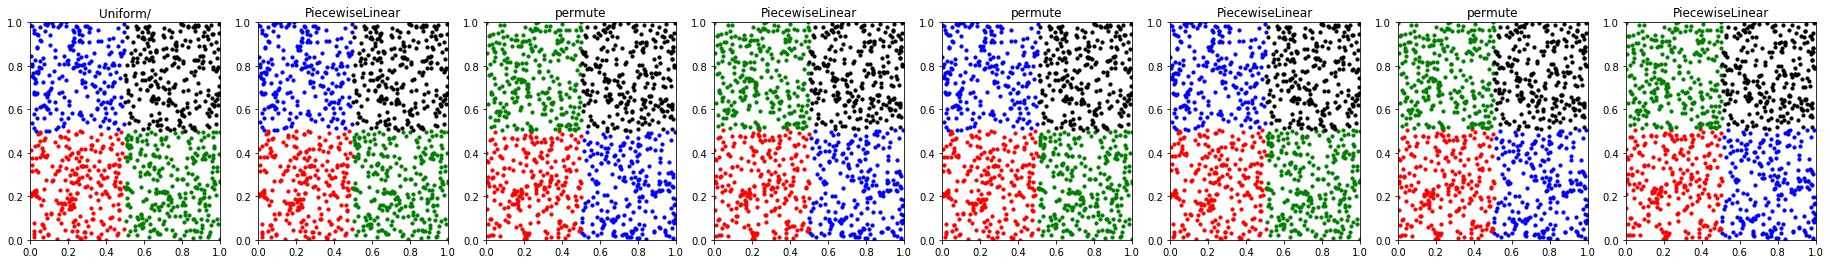

In [421]:
f, arr = plt.subplots(1, len(samples), figsize=(4*len(samples),4))
X0 = samples[0].numpy()
for i in range(len(samples)):
    X1 = samples[i].numpy()
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])